Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the dataset can be adjusted to predict other variables as well.

In this notebook, the dataset will be used for practicing classification techniques on two binned versions of the review_scores_rating variable explored previously.

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

#from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def EncodeCategory(col_to_encode):
    distinct_cats = col_to_encode.unique()
    encode_list = []
    i = 1
    for cat in distinct_cats:
        encode_list.append([cat,i])    
        i += 1
    return(encode_list)

***

# Data Preparation Part 1

<i><b>10 pts.</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</i>

In [3]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [5]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

,grade,review_scores_rating
0,A,100.0
1,A,93.0
2,A,92.0
3,NaN,NaN
4,F,40.0


In [6]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [7]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

In [8]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

In [9]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.

In [10]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','price','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

One-Hot Encode Categorical Variables with multiple levels.

In [11]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

In [12]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 44 columns):
index                     57389 non-null int64
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
host_since                57389 non-null datetime64[ns]
instant

***

# Data Preparation Part 2

<i><b>5 pts.</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</i>

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 36 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non-null bool
air_conditioning                       57389 non-nu

In [14]:
df_final.describe()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,length_amenities,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
count,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,4.749232,3.218247,1.225967,0.952633,26.957326,1.260904,1.737546,18.357943,1373.129380,0.055899,0.071442,0.299465,0.436111,0.087944,0.287355,0.484884,0.001446,0.000174,0.002771,0.010560,0.008608,0.972068,0.399536,0.025144
std,0.668700,2.144154,0.561473,0.122000,41.043449,0.841280,1.265311,6.907464,662.667741,0.229729,0.257564,0.458028,0.495906,0.283215,0.452532,0.499776,0.038003,0.013199,0.052564,0.102216,0.092380,0.164780,0.489807,0.156564
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.304065,2.000000,1.000000,0.940000,3.000000,1.000000,1.000000,14.000000,851.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.700480,2.000000,1.000000,1.000000,11.000000,1.000000,1.000000,18.000000,1312.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.164786,4.000000,1.000000,1.000000,33.000000,1.000000,2.000000,22.000000,1841.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,7.600402,16.000000,8.000000,1.000000,605.000000,10.000000,18.000000,77.000000,3663.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


For the purposes of regression we have created a number of new variables. First, we created log_price, a natural log of the price to amend distribution of the original price variable.

**log_price is an original variable from the dataset, I don't think we need to include it as a newly formed variable**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD15B743C8>]],
      dtype=object)

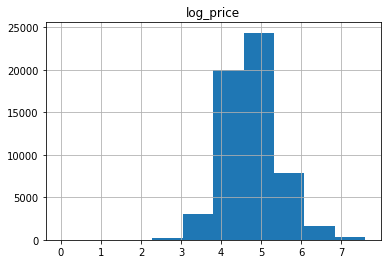

In [15]:
df_final.hist(column='log_price')

As pictured above, the log price has a much more normal distribution. Another attribute we created is the host_since_days, a calculation of how many days a host has been active, defined as the days they became a host subtracted from the current date.

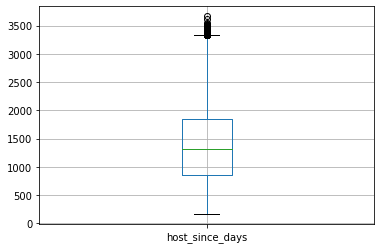

In [16]:
df_final.boxplot(column='host_since_days')

This appears to be right-skewed, with a number of outliers. Some of the hosts look to have been active for a very long time. Another "time-based" variable we created is the length_amenities variable. Some listings have new amenities added, and we created length amenities to create a metric similar to host_since_days.

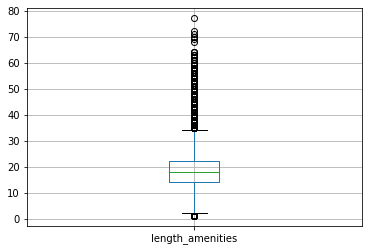

In [17]:
df_final.boxplot(column='length_amenities')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD1A2BAA08>]],
      dtype=object)

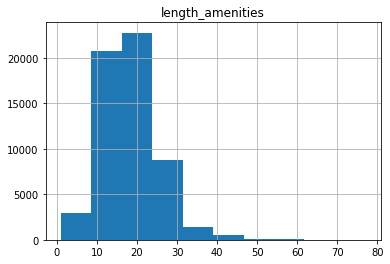

In [18]:
df_final.hist(column='length_amenities')

Very heavy right skew. There are a number of amenities that are very new, which pushes the distribution low, but the large concentration of smaller values pushes the handful of older amenities into outlier territory.
**For the purpose of our first classification task**, we have created a grade_grouped target variable to identify potential hosts that may be targeted for AirBnb's superhost program if they have at least 90% for their rating review scores.

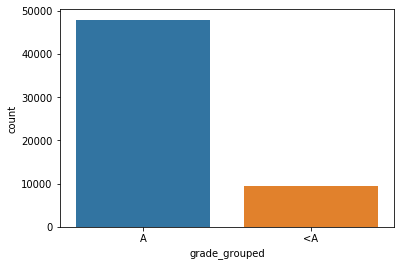

In [19]:
sns.countplot(data=df_imputed, x = 'grade_grouped')

For the grade_grouped target variable, there is a heavy imbalance of classes with 47,897 (83.5%) instances in the dataset reciving a rating review score of 90% or higher. On the other hand, only 9,492 instances recieved a rating review score lower than 90%. Although our EDA, shows a clear separation between the classes of A and <A compared to the 96% cutoff with the superuser variable. With this heavy imbalance, we will attempt to build our classification models using prior probabilities to optimize model performance and prediction accuracy.

**For the purpose of the second classification task**, we decided to subset our dataset based on all listing records that recieved an A or at least 90% on their review scores rating. From there we will use the superuser target variable to further investigate what separates good AirBnb listings (at least 90%) and exceptional listings (at least 96%, the minimum overall rating from reviews to be eligible for the Superhost program). This task will be performed with the dataset named df_superuser_subset.

In [20]:
df_superuser_subset = df_final.loc[df_imputed['grade'] == 'A']
df_superuser_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47897 entries, 0 to 57388
Data columns (total 36 columns):
log_price                              47897 non-null float64
accommodates                           47897 non-null int64
bathrooms                              47897 non-null float64
cleaning_fee                           47897 non-null bool
host_has_profile_pic                   47897 non-null bool
host_identity_verified                 47897 non-null bool
host_response_rate                     47897 non-null float64
instant_bookable                       47897 non-null bool
number_of_reviews                      47897 non-null int64
bedrooms                               47897 non-null int64
beds                                   47897 non-null int64
length_amenities                       47897 non-null int64
internet                               47897 non-null bool
TV                                     47897 non-null bool
air_conditioning                       47897 non-nu

False    27558
True     20339
Name: superuser, dtype: int64

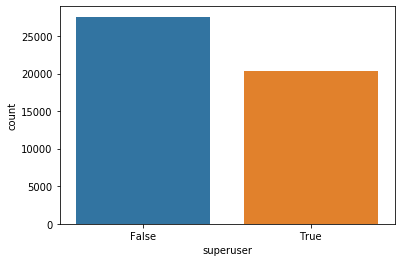

In [21]:
sns.countplot(data=df_superuser_subset, x = 'superuser')
df_superuser_subset['superuser'].value_counts()
#adjust classification penalty against true, class weights, over/under sample

For the superuser target variable in df_superuser_subset, there is a slight imbalance of classes with 27,558 (57.5%) instances in the dataset reciving a rating review score between 90-96%. On the other hand, there are 20,339 instances that recieved a rating review score of 96% and higher.

***

# Modeling and Evaluation 1

<i><b>10 pts.</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</i>

<font color='red'>{EDITED - AN 10/25} For our first classification task with the grade_grouped target responsible, we aim to investigate potential AirBnb hosts that should be targeted for the Superhost program. We will prioritize high precision for the grade_grouped target variable since there is a large majority for the class with an A grade for their ratings review score. With an abundance of instances for this class, we would like to minimize the false positives because we want to correctly determine which AirBnb hosts are ideal for the Superhost program. We also may want to evaluate our model with the F-measure to minimize the false negative predictions because we do not want to miss out on superb hosts that would benefit from the Superhost program. We want to penalize the misclassification of listings with an actual grade of less than A to A more than the misclassification of a listing with an actual grade of A to a grade less than A in the classification models for this first task.
    
For our second classification task with the superuser target variable in df_superuser_subset, we will look into overall classification accuracy since the penalty cost for false negatives and false positives are roughly the same since the classes are not heavily imbalanced. We may also want to investigate precision in the models for this task as well since we want to explore how Superhosts (>=96%) are differentiated from good AirBnb hosts (90-95%).

</font>

***

# Modeling and Evaluation 2

<i><b>10 pts.</b> Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</i>

<font color='red'>{EDITED - AN 10/25} For the first classification task, the proportions of grade groupings are heavily imbalanced; a bar graph shown above demonstrates an approximately 5:1 ratio on A vs everything B and lower. This imbalance warrants a stratified split...

For the second classification task, the proportions on superuser are closer together; a bar graph shown above demonstrates an approximately 1.35:1 ratio on False vs True. Because the disparity is not as strong...

{ADDED}

The method we will use to divide the data into training and test splits will be stratified 10-fold cross validation due to our large class imbalance in the grade_grouped target response variable. With stratified 10-fold cross validation, each fold will be approximately representative of the ratio of classes as the full dataset. In other words, each of the 10 splits of the complete dataset will contain roughly the same percentage of each class from our grade_grouped target response variable.
With a stratified K-fold cross validation technique, we avoid high variance issues of a holdout method while benefiting from the bias and variance reduction of K-fold cross validatoin. The additional stratification of our data splits will address the class imbalance issue in our dataset. We will use this data split technique for both tasks since there is class imbalance present in both datasets, even though the second classification task on the superuser target response variable is only slighltly imbalanced.

</font>

### Task 1: grade_grouped target response

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

# Task 1: grade_grouped target response variable
# separate response variable from training data
X1 = df_final.drop(['superuser','grade_grouped'],axis=1)
y1 = df_final['grade_grouped']
yhat1 = np.zeros(y1.shape) # will be filled with the predictions

# Scale data
scl = StandardScaler()
X1 = scl.fit_transform(X1)

# Create CV iterator
cv = StratifiedKFold(n_splits=10)

# Iterate through CV and get predictions
#for train, test in cv.split(X1,y1):
#    clf.fit(X1[train],y1[train])
#    yhat1[test] = clf.predict(X1[test]) 

### Task 2: superuser target response

In [23]:
# Task 2: superuser target response in df_superuser_subset
# separate response variable from training data
X2 = df_superuser_subset.drop(['superuser','grade_grouped'],axis=1)
y2 = df_superuser_subset['superuser']
yhat2 = np.zeros(y1.shape) # will be filled with the predictions

# Scale data
scl = StandardScaler()
X2 = scl.fit_transform(X2)

# Create CV iterator
cv = StratifiedKFold(n_splits=10)

# Iterate through CV and get predictions
#for train, test in cv.split(X2,y2):
#    clf.fit(X2[train],y2[train])
#    yhat2[test] = clf.predict(X2[test]) 

***

# Modeling and Evaluation 3

<i><b>20 pts.</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</i>

In [24]:
#RF, KNN regression, logistic regression

## Logistic Regression

In [25]:
#logistic regression prep
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [26]:
df.property_type.value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Lighthouse                1
Island                    1
Casa particular           1
Parking Space             1
Name: property_type,

In [27]:
#delete property type because too many values 
df_logistic.drop(['property_type'], axis=1, inplace=True)
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57389 non-null category
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
host_since                57389 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57389 non-null int64
bedrooms                  57389 non-null int64
beds                      57389 non-null int64
price                     57389 non-null float64
grad

In [28]:
df_logistic.dropna(inplace=True)

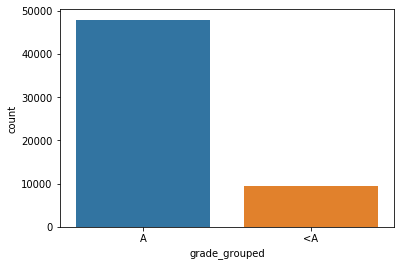

In [29]:
sns.countplot(data=df_logistic, x='grade_grouped')

## Categorical Variable Exploration

In [30]:
#stacked bar chart of percentages
(ggplot(df_logistic, aes('city', fill='grade_grouped'))
 + geom_bar( position='fill')
)


NameError: name 'ggplot' is not defined

In [ ]:
(ggplot(df_logistic, aes('parking', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('pool', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('kitchen', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('air_conditioning', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('TV', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('internet', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('instant_bookable', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('room_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)


In [ ]:
(ggplot(df_logistic, aes('bed_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('cleaning_fee', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('host_has_profile_pic', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('host_identity_verified', fill='grade_grouped'))
 + geom_bar( position='fill')
)

In [ ]:
(ggplot(df_logistic, aes('cancellation_policy', fill='grade_grouped'))
 + geom_bar( position='fill')
)


In [ ]:
df_logistic.info()

In [ ]:
sns.boxplot(x='grade_grouped', y='host_since_days', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='description_length', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='length_amenities', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='price', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='beds', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='bedrooms', data=df_logistic)

In [ ]:
sns.boxplot(x='superuser', y='number_of_reviews', data=df_logistic)

In [ ]:
sns.boxplot(x='superuser', y='host_response_rate', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='bathrooms', data=df_logistic)

In [ ]:
sns.boxplot(x='grade_grouped', y='accommodates', data=df_logistic)

## Logistic Regression without Scaling

In [31]:
# Create dummy variables
categorical_vars = ['parking', 'pool', 'kitchen', 'air_conditioning', 'TV', 'internet', 'instant_bookable',
                   'host_identity_verified', 'host_has_profile_pic', 'city', 'cleaning_fee', 'cancellation_policy',
                   'bed_type', 'room_type']

dummy_df = pd.get_dummies(df_logistic[categorical_vars], drop_first=True)

df_logistic_dummy = pd.concat([df_logistic, dummy_df], axis=1)

df_logistic_dummy.head()

,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,number_of_reviews,bedrooms,beds,price,grade,amenities_new,length_amenities,internet,TV,air_conditioning,kitchen,pool,parking,description_length,superuser,grade_grouped,host_since_days,parking,pool,kitchen,air_conditioning,TV,internet,instant_bookable,host_identity_verified,host_has_profile_pic,cleaning_fee,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,2016-06-18,True,True,0.924026,2012-03-26,False,2016-07-18,2,1,1,150.0,A,"[wireless internet, air conditioning, kitchen,...",9,True,False,True,True,False,False,211,True,A,2179,False,False,True,True,False,True,False,True,True,True,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,2017-08-05,True,False,1.000000,2017-06-19,True,2017-09-23,6,3,3,169.0,A,"[wireless internet, air conditioning, kitchen,...",15,True,False,True,True,False,False,1000,False,A,268,False,False,True,True,False,True,True,False,True,True,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,2017-04-30,True,True,1.000000,2016-10-25,True,2017-09-14,10,1,3,145.0,A,"[tv, cable tv, wireless internet, air conditio...",19,True,True,True,True,False,False,1000,False,A,505,False,False,True,True,True,True,True,True,True,True,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,2015-05-12,True,True,1.000000,2015-03-01,True,2017-01-22,4,0,1,115.0,F,"[tv, internet, wireless internet, air conditio...",12,True,True,True,True,False,False,699,False,<A,1109,False,False,True,True,True,True,True,True,True,True,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,Private room,2,1.0,Real Bed,strict,True,SF,2017-08-27,True,True,1.000000,2017-06-07,True,2017-09-05,3,1,1,85.0,A,"[tv, wireless internet, heating, smoke detecto...",10,True,True,False,False,False,False,1000,False,A,280,False,False,False,False,True,True,True,True,True,True,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [32]:
#delete categorical variables
for x in categorical_vars:
    if x in df_logistic_dummy:
        del df_logistic_dummy[x]

df_logistic_dummy.head()

,accommodates,bathrooms,first_review,host_response_rate,host_since,last_review,number_of_reviews,bedrooms,beds,price,grade,amenities_new,length_amenities,description_length,superuser,grade_grouped,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,3,1.0,2016-06-18,0.924026,2012-03-26,2016-07-18,2,1,1,150.0,A,"[wireless internet, air conditioning, kitchen,...",9,211,True,A,2179,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,7,1.0,2017-08-05,1.000000,2017-06-19,2017-09-23,6,3,3,169.0,A,"[wireless internet, air conditioning, kitchen,...",15,1000,False,A,268,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,5,1.0,2017-04-30,1.000000,2016-10-25,2017-09-14,10,1,3,145.0,A,"[tv, cable tv, wireless internet, air conditio...",19,1000,False,A,505,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,2,1.0,2015-05-12,1.000000,2015-03-01,2017-01-22,4,0,1,115.0,F,"[tv, internet, wireless internet, air conditio...",12,699,False,<A,1109,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2,1.0,2017-08-27,1.000000,2017-06-07,2017-09-05,3,1,1,85.0,A,"[tv, wireless internet, heating, smoke detecto...",10,1000,False,A,280,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [33]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57388 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57388 non-null category
accommodates              57388 non-null int64
bathrooms                 57388 non-null float64
bed_type                  57388 non-null category
cancellation_policy       57388 non-null category
cleaning_fee              57388 non-null bool
city                      57388 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57388 non-null bool
host_identity_verified    57388 non-null bool
host_response_rate        57388 non-null float64
host_since                57388 non-null datetime64[ns]
instant_bookable          57388 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57388 non-null int64
bedrooms                  57388 non-null int64
beds                      57388 non-null int64
price                     57388 non-null float64
grad

In [34]:
#delete amenities_new because used to create other variables
del df_logistic_dummy['amenities_new']

#delete host_since because used to create host_since_days
del df_logistic_dummy['host_since']

#delete grade and superuser because redundant with grouped_grade
del df_logistic_dummy['grade']
del df_logistic_dummy['superuser']

In [35]:
#remove timestamps
del df_logistic_dummy['first_review']
del df_logistic_dummy['last_review']

df_logistic_dummy.head()

,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,description_length,grade_grouped,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
0,3,1.0,0.924026,2,1,1,150.0,9,211,A,2179,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,7,1.0,1.000000,6,3,3,169.0,15,1000,A,268,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,5,1.0,1.000000,10,1,3,145.0,19,1000,A,505,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,2,1.0,1.000000,4,0,1,115.0,12,699,<A,1109,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2,1.0,1.000000,3,1,1,85.0,10,1000,A,280,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [36]:
#Creating training and testing data
from sklearn.model_selection import ShuffleSplit
X = df_logistic_dummy.drop(['grade_grouped'], axis=1).values
X

array([[3.        , 1.        , 0.92402581, ..., 1.        , 0.        ,
        0.        ],
       [7.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [5.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [4.        , 2.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [5.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [4.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [37]:
y = df_logistic_dummy['grade_grouped'].values
y

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

In [38]:
#create cross validation object for 80/20 split
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
cv_object

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
#create logistic regression object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
accuracies

array([0.83481443, 0.83943196, 0.83908346])

## Random Forest Task 1

In [40]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 44 columns):
index                     57389 non-null int64
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
host_since                57389 non-null datetime64[ns]
instant

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

cv_strat_obj = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, train_size=0.8, random_state=0)
X_rf = df_final.drop(['grade_grouped'], axis=1).values
y_rf = df_final['grade_grouped'].values
cv_strat_obj.split(X_rf, y_rf)
cv_strat_obj

StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=0.8)

In [42]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
for train_index, test_index in cv_strat_obj.split(X_rf, y_rf):
    X_trainrf, X_testrf = X_rf[train_index], X_rf[test_index]
    y_trainrf, y_testrf = y_rf[train_index], y_rf[test_index]

In [45]:
rfc.fit(X_trainrf, y_trainrf) 
print(rfc.feature_importances_)

[1.23133589e-01 9.36012797e-03 1.45407923e-03 1.03862193e-02
 0.00000000e+00 1.92208474e-02 1.63135059e-01 1.08392510e-01
 5.24478382e-02 1.25728834e-03 1.29083704e-02 2.03365927e-01
 3.93355484e-02 5.89690109e-02 1.83634347e-03 1.71036042e-04
 3.02387941e-03 6.88594045e-03 4.03822204e-04 3.97605338e-02
 1.29948558e-03 0.00000000e+00 2.22716635e-03 5.08033287e-02
 2.65804388e-03 5.36703678e-02 2.10485000e-02 1.37758506e-03
 0.00000000e+00 1.20852178e-04 0.00000000e+00 0.00000000e+00
 9.57405276e-04 0.00000000e+00 1.03892950e-02]


In [46]:
rfc.predict(X_testrf)

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

## Random Forest Task 2

In [47]:
X_rf2 = df_superuser_subset.drop(['superuser','grade_grouped'], axis=1).values
y_rf2 = df_superuser_subset['superuser'].values
rfc2 = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
cv_strat_obj.split(X_rf2, y_rf2)

for train_index, test_index in cv_strat_obj.split(X_rf2, y_rf2):
    X_trainrf2, X_testrf2 = X_rf2[train_index], X_rf2[test_index]
    y_trainrf2, y_testrf2 = y_rf2[train_index], y_rf2[test_index]

In [50]:
rfc2.fit(X_trainrf2, y_trainrf2) 
print(rfc2.feature_importances_)

[0.13350714 0.10478374 0.10496732 0.01090054 0.00668947 0.00942935
 0.05066461 0.01100382 0.0955352  0.04628282 0.04031114 0.09661553
 0.00841643 0.00798175 0.02518625 0.00208763 0.00742997 0.01390764
 0.0962322  0.00566491 0.01526918 0.00082808 0.01358862 0.01419482
 0.0090408  0.00431805 0.01192678 0.00220267 0.01421544 0.00920299
 0.00224297 0.00775258 0.00569116 0.01192837]


In [49]:
rfc2.predict(X_testrf2)

array([False, False, False, ..., False, False, False])

## K Nearest Neighbors

The K nearest neighbors (KNN) algorithm uses some defined distance metric to compare an unknown record to known training data and produce a classification label. Therefore, any numeric (int or float) variables are usable. Boolean attributes translate cleanly and are easily usable as well. Conversely, certain categoric variables (such as room type or city) cannot have number assignments because they would incorrectly imply order. These should be omitted.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Remove object or datetime variables
df_knn = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'name', 'neighbourhood',
                        'review_scores_rating', 'thumbnail_url', 'zipcode', 'property_type', 'room_type', 'city',
                        'amenities_new', 'first_review', 'host_since', 'last_review', 'grade', 'bed_type',
                        'cancellation_policy'],
                         axis=1)

# Modify target grade_grouped to boolean to enable pos/neg classes for precision
df_knn['grade_grouped'] = df_knn['grade_grouped'].replace({'A':True, 'B and lower':False})
df_knn['grade_grouped'] = df_knn['grade_grouped'].astype(np.bool)

# All remaining variables are numeric
df_knn.info()

In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_knn)
df_knn.loc[:,:] = scaled_values
df_knn.describe()

In [ ]:
cv_strat_obj = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, train_size=0.8, random_state=0)
X_knn = df_knn.drop(['grade_grouped'], axis=1).values
y_knn = df_knn['grade_grouped'].values
cv_strat_obj.split(X_knn, y_knn)

model_knn1 = KNeighborsClassifier()
for train_index, test_index in cv_strat_obj.split(X_knn, y_knn):
    X_trainknn, X_testknn = X_knn[train_index], X_knn[test_index]
    y_trainknn, y_testknn = y_knn[train_index], y_knn[test_index]

In [ ]:
# fill in your code  here to train and test
#for K in range(1,3):
#    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
#    clf.fit(X_trainknn,y_trainknn)
#    y_hat = clf.predict(X_testknn)
#    pre = precision_score(y_testknn, y_hat)
#    print('Precision of classifier with %d neighbors is: %.2f'%(K,pre))

# Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': [4,5,6,7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree', 'brute', 'ball_tree'],
    'n_jobs': [-1]
}
scores = ['precision', 'recall']

for score in scores:
    grid_knn = GridSearchCV(knn, param_grid=parameters, scoring=scores,
                           refit=False)
    grid_knn.fit(X_trainknn, y_trainknn)
    
    print("Best parameters set found for training data:")
    print(grid_knn.best_params_)
    
    y_true, y_pred = y_testknn, grid_knn.predict(X_testknn)
    print(classification_report(y_true, y_pred))

***

# Modeling and Evaluation 4

<i><b>10 pts.</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</i>

In [ ]:
#Conf matrix, ROC curve, plotting feature importance/accuracy, MSE? Scree plot for K neighbors

In [72]:
from sklearn.metrics import roc_curve, auc

rf_predictions = rfc.predict(X_testrf)

probs = rfc.predict_proba(X_testrf)
roc_curve(y_testrf,probs[0][:1])

ValueError: Found input variables with inconsistent numbers of samples: [11478, 1]

In [69]:
probs[0][:1]

array([0.1817969])

***

# Modeling and Evaluation 5

<i><b>10 pts.</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</i>

In [ ]:
#focus on precision with f measure, p test, check 7.17 module

***

# Modeling and Evaluation 6

<i><b>10 pts.</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</i>

In [ ]:
#feature importance from RF, iterate/optimize K neighbors, f test on regression

***

# Deployment

<i><b>5 pts.</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</i>

In [ ]:
#clarify in class, explaining profit to shareholders (superhosts provide more to Airbnb than regular hosts, we can identify users that meet those requirements and can actively recruit for the program)

***

# Exceptional Work

<i><b>10 pts.</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</i>

In [ ]:
#smoat, lasso/ridge